# Thông tin đồ án:


- Chủ đề: Crowd Counting
- Lớp: CS117.N21.KHTN
- Giảng viên: TS. Ngô Đức Thành
- Sinh viên 1: Nguyễn Tuấn Anh - 21520142
- Sinh viên 2: Hà Văn Hoàng - 21520033
- Sinh viên 3: Phan Trường Trí - 21520117
- Sinh viên 4: Lương Toàn Bách - 21521845
- Sinh viên 5: Nguyễn Trường Thịnh - 21520110

# Chuẩn bị các thư viện cần thiết

In [ ]:
import pandas as pd
import numpy as np
import scipy
import scipy.io
import cv2

from matplotlib import pyplot as plt

from scipy.ndimage import gaussian_filter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from PIL import Image

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning import seed_everything

import os

from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

# Chuẩn bị dữ liệu

In [ ]:
def show(im):
  plt.figure(figsize=(10, 10))
  plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In [ ]:
from sklearn.model_selection import train_test_split

train = [p.path for p in os.scandir('ShanghaiTech\\part_B\\train_data\\images\\')]
test = [p.path for p in os.scandir('ShanghaiTech\\part_B\\test_data\\images\\')]
train, valid = train_test_split(train, test_size=50, random_state=42)

In [ ]:
aug_train = A.Compose([
    A.Normalize((0.5), (0.5)),
], keypoint_params=A.KeypointParams(format='xy', angle_in_degrees=False))

aug_val_test = A.Compose([
    A.Normalize((0.5), (0.5)),
], keypoint_params=A.KeypointParams(format='xy', angle_in_degrees=False))

class MyDataset(Dataset):
  def __init__(self, files, aug):
    self.files = files
    self.aug = aug

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    fn = self.files[idx]

    im = cv2.imread(fn, cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    m = scipy.io.loadmat(fn.replace('images', 'ground-truth').replace('IMG', 'GT_IMG').replace('.jpg', '.mat'))
    ps = m['image_info'][0][0][0][0][0]

    rst = self.aug(image=im, keypoints=ps)
    im = rst['image']
    ps = rst['keypoints']

    dm = np.zeros((im.shape[0], im.shape[1]), dtype=np.float32)
    for x, y in ps:
      x = int(x)
      y = int(y)
      dm[y, x] = 1

    sigma = 4
    dm = gaussian_filter(dm, sigma=sigma, truncate=4*sigma)
    dm = cv2.resize(dm, (im.shape[1] // 4, im.shape[0] // 4), interpolation=cv2.INTER_LINEAR)
    dm *= 16

    im = torch.from_numpy(im)
    dm = torch.from_numpy(dm)

    return im, dm

# Dựng mô hình MCNN

In [ ]:
class Conv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, relu=True, same_padding=False, bn=False):
    super(Conv2d, self).__init__()
    padding = int((kernel_size - 1) / 2) if same_padding else 0
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding)
    self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0, affine=True) if bn else None
    self.relu = nn.ReLU(inplace=True) if relu else None

  def forward(self, x):
    x = self.conv(x)
    if self.bn is not None:
      x = self.bn(x)
    if self.relu is not None:
      x = self.relu(x)
    return x

In [ ]:
class MCNN(LightningModule):
  '''
  Multi-column CNN
  -Implementation of Single Image Crowd Counting via Multi-column CNN (Zhang et al.)
  '''

  def __init__(self, lr, max_steps, bn=False):
    super(MCNN, self).__init__()

    self.lr = lr
    self.save_hyperparameters()

    self.branch1 = nn.Sequential(Conv2d( 1, 16, 9, same_padding=True, bn=bn),
                                  nn.MaxPool2d(2),
                                  Conv2d(16, 32, 7, same_padding=True, bn=bn),
                                  nn.MaxPool2d(2),
                                  Conv2d(32, 16, 7, same_padding=True, bn=bn),
                                  Conv2d(16,  8, 7, same_padding=True, bn=bn))

    self.branch2 = nn.Sequential(Conv2d( 1, 20, 7, same_padding=True, bn=bn),
                                  nn.MaxPool2d(2),
                                  Conv2d(20, 40, 5, same_padding=True, bn=bn),
                                  nn.MaxPool2d(2),
                                  Conv2d(40, 20, 5, same_padding=True, bn=bn),
                                  Conv2d(20, 10, 5, same_padding=True, bn=bn))

    self.branch3 = nn.Sequential(Conv2d( 1, 24, 5, same_padding=True, bn=bn),
                                  nn.MaxPool2d(2),
                                  Conv2d(24, 48, 3, same_padding=True, bn=bn),
                                  nn.MaxPool2d(2),
                                  Conv2d(48, 24, 3, same_padding=True, bn=bn),
                                  Conv2d(24, 12, 3, same_padding=True, bn=bn))

    self.fuse = nn.Sequential(Conv2d( 30, 1, 1, same_padding=True, bn=bn))
    self.crit = nn.MSELoss()

  def forward(self, im_data):
    im_data = im_data.unsqueeze(1)
    x1 = self.branch1(im_data)
    x2 = self.branch2(im_data)
    x3 = self.branch3(im_data)
    x = torch.cat((x1,x2,x3),1)
    x = self.fuse(x)

    return x.squeeze(1)


  def training_step(self, batch, batch_idx):
    self.train()
    x, y = batch

    pred = self(x)
    loss = self.crit(pred, y)

    pred_sum = torch.round(pred.sum(dim=(1,2))).int()
    gt_sum = torch.round(y.sum(dim=(1,2))).int()

    mae = torch.abs(pred_sum - gt_sum).float().mean()
    mse = torch.pow(pred_sum - gt_sum, 2).float().mean()

    self.log('train_mae', mae)
    self.log('train_mse', mse)

    return loss

  def validation_step(self, batch, batch_idx):
    with torch.no_grad():
      self.eval()
      x, y = batch

      pred = self(x)
      pred_sum = torch.round(pred.sum(dim=(1,2))).int()
      gt_sum = torch.round(y.sum(dim=(1,2))).int()

      mae = torch.abs(pred_sum - gt_sum).float().mean()
      mse = torch.pow(pred_sum - gt_sum, 2).float().mean()

      self.log('val_mae', mae)
      self.log('val_mse', mse)

  def test_step(self, batch, batch_idx):
    with torch.no_grad():
      self.eval()
      x, y = batch

      pred = self(x)
      pred_sum = torch.round(pred.sum(dim=(1,2))).int()
      gt_sum = torch.round(y.sum(dim=(1,2))).int()

      mae = torch.abs(pred_sum - gt_sum).float().mean()
      mse = ((pred_sum - gt_sum)**2).float().mean()

      self.log('test_mae', mae)
      self.log('test_mse', mse)

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)

    scheduler = {
      'scheduler': torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.lr, total_steps=self.hparams.max_steps, pct_start=0.1, cycle_momentum=False),
      'interval': 'step',
      'frequency': 1
    }

    return [optimizer], [scheduler]

In [ ]:
def weights_normal_init(model, dev=0.01):
  if isinstance(model, list):
    for m in model:
      weights_normal_init(m, dev)
  else:
    for n, m in model.named_modules():
      if isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, dev)
        if m.bias is not None:
          m.bias.data.fill_(0.0)
      elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0.0, dev)

# Training - Testing

In [ ]:
seed_everything(42)
lr = 3e-4

Global seed set to 42


In [ ]:
checkpoint = ModelCheckpoint(
  save_top_k = 1,
  save_last = True,
  verbose = True,
  monitor = 'val_mae',
  mode = 'min',
)

train_data = MyDataset(train, aug_train)
val_data = MyDataset(valid, aug_val_test)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, drop_last=True, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=4, shuffle=False, drop_last=False, pin_memory=True)

max_steps = (len(train) // 4) * 10
trainer = Trainer(accelerator='gpu', devices=1, max_steps=max_steps, precision="16-mixed", benchmark=True, callbacks=[checkpoint, LearningRateMonitor()])

model = MCNN(lr, max_steps=max_steps)
weights_normal_init(model, dev=0.01)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | branch1 | Sequential | 57.8 K
1 | branch2 | Sequential | 46.1 K
2 | branch3 | Sequential | 24.0 K
3 | fuse    | Sequential | 31    
4 | crit    | MSELoss    | 0     
---------------------------------------
127 K     Trainable params
0         Non-trainable params
127 K     Total params
0.512     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\havan\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


C:\Users\havan\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 87/87 [02:45<00:00,  1.90s/it, v_num=4] 
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 87/87 [02:58<00:00,  2.06s/it, v_num=4]       

Epoch 0, global step 87: 'val_mae' reached 64.64000 (best 64.64000), saving model to 'C:\\Users\\havan\\MCNN\\lightning_logs\\version_4\\checkpoints\\epoch=0-step=87.ckpt' as top 1


Epoch 1: 100%|██████████| 87/87 [01:53<00:00,  1.30s/it, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 87/87 [01:57<00:00,  1.36s/it, v_num=4]       

Epoch 1, global step 174: 'val_mae' reached 58.12000 (best 58.12000), saving model to 'C:\\Users\\havan\\MCNN\\lightning_logs\\version_4\\checkpoints\\epoch=1-step=174.ckpt' as top 1


Epoch 2: 100%|██████████| 87/87 [01:52<00:00,  1.30s/it, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 87/87 [01:57<00:00,  1.35s/it, v_num=4]       

Epoch 2, global step 261: 'val_mae' was not in top 1


Epoch 3: 100%|██████████| 87/87 [01:53<00:00,  1.30s/it, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 87/87 [01:57<00:00,  1.35s/it, v_num=4]       

Epoch 3, global step 348: 'val_mae' reached 56.54000 (best 56.54000), saving model to 'C:\\Users\\havan\\MCNN\\lightning_logs\\version_4\\checkpoints\\epoch=3-step=348.ckpt' as top 1


Epoch 4: 100%|██████████| 87/87 [01:52<00:00,  1.30s/it, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 87/87 [01:57<00:00,  1.35s/it, v_num=4]       

Epoch 4, global step 435: 'val_mae' reached 53.98000 (best 53.98000), saving model to 'C:\\Users\\havan\\MCNN\\lightning_logs\\version_4\\checkpoints\\epoch=4-step=435.ckpt' as top 1


Epoch 5: 100%|██████████| 87/87 [01:58<00:00,  1.36s/it, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 87/87 [02:02<00:00,  1.41s/it, v_num=4]       

Epoch 5, global step 522: 'val_mae' reached 50.88000 (best 50.88000), saving model to 'C:\\Users\\havan\\MCNN\\lightning_logs\\version_4\\checkpoints\\epoch=5-step=522.ckpt' as top 1


Epoch 6: 100%|██████████| 87/87 [01:59<00:00,  1.37s/it, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 87/87 [02:03<00:00,  1.42s/it, v_num=4]       

Epoch 6, global step 609: 'val_mae' reached 50.76000 (best 50.76000), saving model to 'C:\\Users\\havan\\MCNN\\lightning_logs\\version_4\\checkpoints\\epoch=6-step=609.ckpt' as top 1


Epoch 7: 100%|██████████| 87/87 [01:54<00:00,  1.32s/it, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 87/87 [01:59<00:00,  1.37s/it, v_num=4]       

Epoch 7, global step 696: 'val_mae' was not in top 1


Epoch 8: 100%|██████████| 87/87 [01:53<00:00,  1.30s/it, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 87/87 [01:57<00:00,  1.35s/it, v_num=4]       

Epoch 8, global step 783: 'val_mae' was not in top 1


Epoch 9: 100%|██████████| 87/87 [01:53<00:00,  1.30s/it, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 87/87 [01:57<00:00,  1.35s/it, v_num=4]       

Epoch 9, global step 870: 'val_mae' reached 50.26000 (best 50.26000), saving model to 'C:\\Users\\havan\\MCNN\\lightning_logs\\version_4\\checkpoints\\epoch=9-step=870.ckpt' as top 1
`Trainer.fit` stopped: `max_steps=870` reached.


Epoch 9: 100%|██████████| 87/87 [01:57<00:00,  1.35s/it, v_num=4]


In [ ]:
test_loader = DataLoader(MyDataset(test, aug_val_test), batch_size=4, shuffle=False, drop_last=False, pin_memory=True)
trainer.test(dataloaders = test_loader)

C:\Users\havan\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at C:\Users\havan\MCNN\lightning_logs\version_4\checkpoints\epoch=9-step=870.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at C:\Users\havan\MCNN\lightning_logs\version_4\checkpoints\epoch=9-step=870.ckpt
C:\Users\havan\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the numbe

Testing DataLoader 0: 100%|██████████| 79/79 [00:26<00:00,  2.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae             45.50632858276367
        test_mse             5509.56982421875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_mae': 45.50632858276367, 'test_mse': 5509.56982421875}]

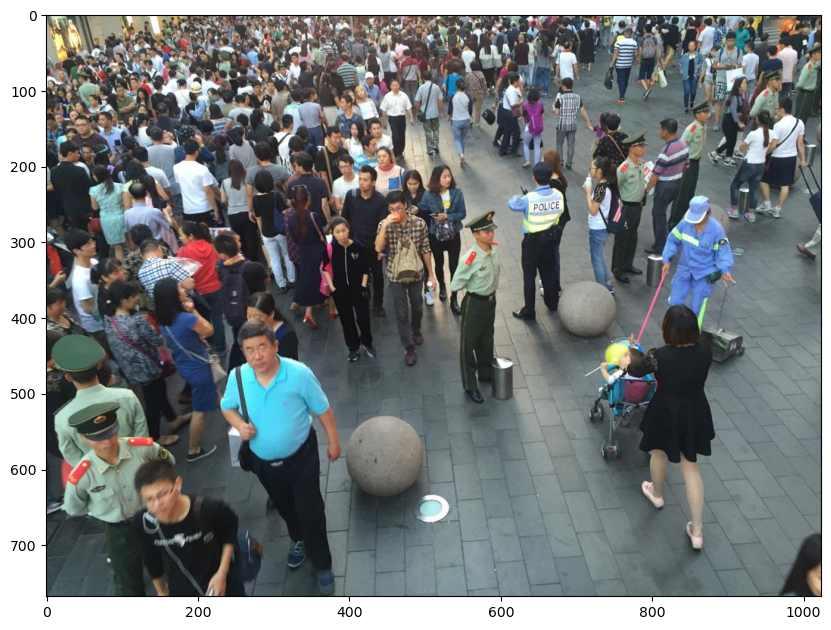

In [ ]:
ds = MyDataset(test, aug_val_test)
im, dm = ds[23]
show(cv2.imread(test[23], cv2.IMREAD_COLOR))

513

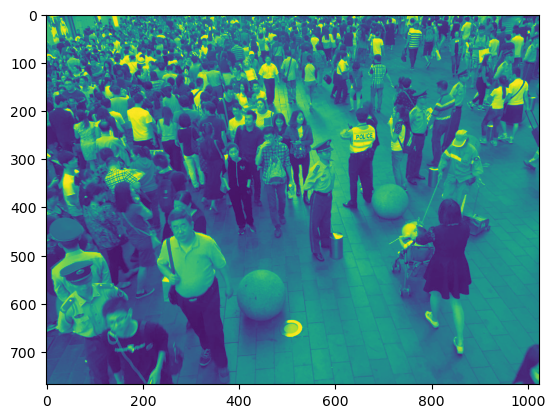

In [ ]:
plt.imshow(im)
m = scipy.io.loadmat(test[23].replace('images', 'ground-truth').replace('IMG', 'GT_IMG').replace('.jpg', '.mat'))
ps = m['image_info'][0][0][0][0][0]
len(ps)

tensor(513.)

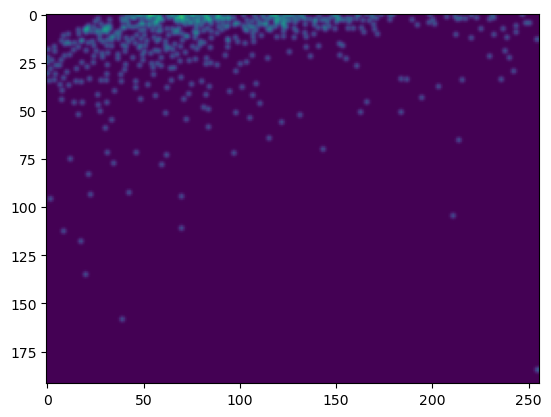

In [ ]:
plt.imshow(dm)
dm.sum()

tensor(182.)

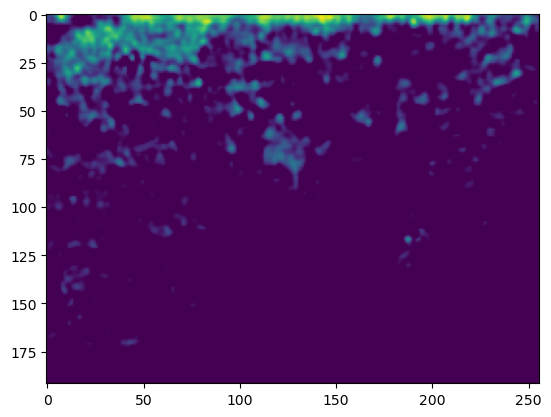

In [ ]:
plt.imshow(model(im.unsqueeze(0)).detach()[0])
torch.round(model(im.unsqueeze(0)).detach()[0].sum())